# Part 1 : import libs and some useful functions

In [2]:
from IPython.display import display
import pandas as pd
import numpy as np
import gc
import keras
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn import preprocessing
from sklearn import feature_extraction
from sklearn.linear_model import LinearRegression
from tqdm import tqdm, tqdm_notebook
from itertools import product

## Downcast float64 to float32 and int64 to int32 to save memory
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# input sklearn tree classifier, training dataset
# plots feature importance and lists features in order of importance
# returns ranked list of columns from training dataframe
def feature_importance(forest, X_train):
    ranked_list = []
    
    importances = forest.feature_importances_

    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X_train.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]) + " - " + X_train.columns[indices[f]])
        ranked_list.append(X_train.columns[indices[f]])

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X_train.shape[1]), indices)
    plt.xlim([-1, X_train.shape[1]])
    plt.show()
    
    return ranked_list
    
def split_data(all_data, test_block=34, start_block=-1, to_drop_cols=[]):
    dates = all_data['date_block_num']
    dates_train  = dates[dates <  test_block]
    dates_test  = dates[dates == test_block]
    
    y_train = all_data.loc[(dates <  test_block) & (dates > start_block), 'target']
    y_test =  all_data.loc[dates == test_block, 'target']
    
    # split the data into train and test
    X_train = all_data.drop(["target", "date_block_num"] + to_drop_cols, axis=1).loc[(dates <  test_block) & (dates > start_block)]
    X_test =  all_data.drop(["target", "date_block_num"] + to_drop_cols, axis=1).loc[dates == test_block]
    
    print("X_train:", X_train.shape)
    print("X_test:", X_test.shape)
    
    return X_train, y_train, X_test, y_test

def weighted_average(arr_1, arr_2, weight=0.66):
    averaged = ( (1-weight * arr_1) + (weight * arr_2) ) / 2
    return averaged

Using TensorFlow backend.


# Part 2 : Data Analysis

In [108]:
import os 
DATA_FOLDER = './final_project_data/'

sales      = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items      = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_cats  = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops      = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))

In [112]:
sales['day'] = sales.date.str.split('.').str.get(0)
sales['month'] = sales.date.str.split('.').str.get(1)
sales['year'] = sales.date.str.split('.').str.get(2)

In [109]:
def year_data(year, transactions):
    sale_Month_Rev = [0 for i in range(12)]
    yeardata = transactions.loc[transactions.year == str(year)]
    yeardata['sum'] = yeardata['item_price'] * yeardata['item_cnt_day']
    if len(yeardata) > 0:
        for i in range(12):
            if i < 10:
                monthdata = yeardata.loc[yeardata.month == '0' + str(i+1)]
            else:
                monthdata = yeardata.loc[yeardata.month ==str(i)]
            sale_Month_Rev[i] = np.sum(monthdata['sum'])
    return sale_Month_Rev
def category_year_per(year, transactions, items, categoryId):
    category_data = items.loc[items.item_category_id == categoryId]
    category_transactions = transactions.loc[transactions['item_id'].isin(category_data['item_id'])]
    sale_Month_Rev = year_data(year, transactions)
    category_Month_Rev = year_data(year, category_transactions)
    sale_Month_Rev = [sale_Month_Rev[i]+1 for i in range(12)]
    return [category_Month_Rev[i]/sale_Month_Rev[i] for i in range(12)]
def category_performance(year, transactions, items, Isplot):
    yeardata = transactions.loc[transactions.year == str(year)]
    MaxGor = max(items['item_category_id'])
    MinGor = min(items['item_category_id'])
    all_Category = np.zeros((MaxGor - MinGor+1), dtype=np.float32)
    for i in range(MinGor, MaxGor+1):
        category_data = items.loc[items.item_category_id == i]
        category_transactions = yeardata.loc[yeardata['item_id'].isin(category_data['item_id'])]
        all_Category[i] = np.sum(category_transactions['item_price'] * category_transactions['item_cnt_day'])
    if Isplot:
        plt.plot(all_Category/np.sum(all_Category), label="year :" + str(year))
        plt.ylabel('Income Percentage')
        plt.xlabel('Category ID')
        plt.title("Category performance")
        plt.legend()
        plt.show()
    return (all_Category)

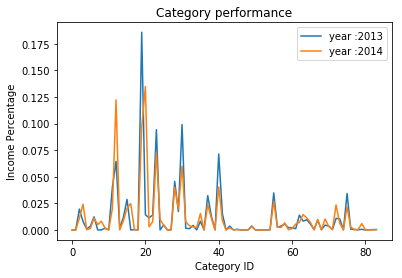

[12 40 23 30 19]
[30 23 19 12 20]


In [113]:
Cate_13 = category_performance(2013, sales, items, False)
Cate_14 = category_performance(2014, sales, items, False)
plt.plot(Cate_13/np.sum(Cate_13), label="year :" + str(2013))
plt.plot(Cate_14/np.sum(Cate_14), label="year :" + str(2014))
plt.ylabel('Income Percentage')
plt.xlabel('Category ID')
plt.title("Category performance")
plt.legend()
plt.show()
print(Cate_13.argsort()[-5:])
print(Cate_14.argsort()[-5:])

/home/minomi016/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


==========2013
[91947091.1299997, 90665707.36999977, 104932687.1499996, 69154285.54999954, 65065312.459999666, 79550405.82999893, 69350599.8799999, 74297969.64000005, 119081891.68000044, 0, 107241612.52999991, 138665439.30000573]
==========2014
[98226022.94999976, 107431122.75999957, 109115405.33999792, 80651755.21999972, 91281733.83000056, 82668538.6599995, 76487921.3199997, 89604092.27000004, 114723593.96999823, 0, 112525522.33999938, 152037599.33999887]
==========2015
[118927699.77999905, 86593883.89000057, 86476266.59999973, 90252813.75999585, 88577438.23999824, 65397995.42999958, 59405787.169999816, 61748964.71000002, 92905169.14000146, 0, 84337113.06000003, 0]


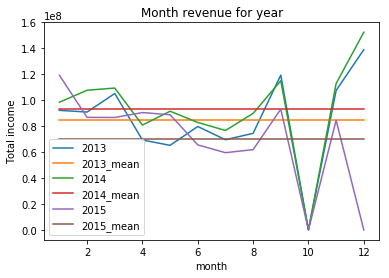

In [115]:
for i in range(int(min(sales['year'])), int(max(sales['year'])) +1):
    saleNum = year_data(i, sales)
    print('==========' + str(i))
    print(saleNum)
    saleMean = np.mean(saleNum)
    plt.plot([i+1 for i in range(12)], saleNum, label = str(i))
    plt.plot([i+1 for i in range(12)], [saleMean for i in range(12)],  label=str(i) + '_mean')
plt.ylabel('Total income')
plt.xlabel('month')
plt.title("Month revenue for year")
plt.legend()
plt.show()

## Data preprocessing

In [19]:
import os 
def All_data():
    DATA_FOLDER = './final_project_data/'
    sales      = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
    items      = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
    item_cats  = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
    shops      = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
    test       = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv'))
    test_block = sales['date_block_num'].iloc[-1] + 1
    test['date_block_num'] = test_block
    test.head()
    # Create "grid" with columns
    index_cols = ['shop_id', 'item_id', 'date_block_num']

    # For every month we create a grid from all shops/items combinations from that month
    grid = [] 
    for block_num in sales['date_block_num'].unique():
        cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
        cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
        grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

    # Turn the grid into a dataframe
    grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
    grid = pd.concat([grid, test])

    # Groupby data to get shop-item-month aggregates
    gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
    # Fix column names
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
    # Join it to the grid
    all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

    # Same as above but with shop-month aggregates
    gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
    gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

    # Same as above but with item-month aggregates
    gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
    gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
    all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

    # Downcast dtypes from 64 to 32 bit to save memory
    all_data = downcast_dtypes(all_data)
    del grid, gb 
    gc.collect();

    print("time lags")
    # List of columns that we will use to create lags
    cols_to_rename = list(all_data.columns.difference(['ID'] + index_cols)) 
    print(cols_to_rename)
    # use sales from selected months in last year to get the lags
    shift_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

    # loop through the month shifts
    for month_shift in shift_range:
        train_shift = all_data[cols_to_rename + index_cols].copy()
        # update the date block by the month shift
        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift

        # rename the columns
        col_names = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
        train_shift = train_shift.rename(columns=col_names)
        print(month_shift, train_shift.head())
        # merge the lag data back into the dataframe
        all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)
        
        del(train_shift)

    # any date block less than 12 doesn't have lag info, so let's discard those from our training data
    all_data = all_data[all_data.date_block_num >= 12]

    # List of all lagged features
    fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 

    # decide which columns we can drop later
    to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

    # add the month number as a column
    all_data['month_number'] = (all_data['date_block_num'] + 1) % 12
    all_data.loc[all_data.month_number == 0, 'month_number'] = 12

    # downcast to save memory
    all_data = downcast_dtypes(all_data)
    gc.collect();
    
    print("create text features for items")
    feature_cnt = 25

    # extract the features
    tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)

    # length of text string
    items['item_name_len'] = items['item_name'].map(len)

    # number of words
    items['item_name_wc'] = items['item_name'].map(lambda x: len(str(x).split(' ')))

    txtFeatures = pd.DataFrame(tfidf.fit_transform(items['item_name']).toarray())
    cols = txtFeatures.columns

    # loop through the features and add it to the items dataframe
    for i in range(feature_cnt):
        items['item_name_tfidf_' + str(i)] = txtFeatures[cols[i]]

    # drop the item name and just keep the encoded features
    items.drop('item_name', axis=1, inplace=True)
    items.head()
    all_data = pd.merge(all_data, items, how='left', on='item_id')
    
    print("Features for item categories")
    # extract the features
    tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)

    # length of category name
    item_cats['item_category_name_len'] = item_cats['item_category_name'].map(len)

    txtFeatures = pd.DataFrame(tfidf.fit_transform(item_cats['item_category_name']).toarray())
    cols = txtFeatures.columns

    # loop through the features and create a column containing it
    for i in range(feature_cnt):
        item_cats['item_category_name_tfidf_' + str(i)] = txtFeatures[cols[i]]

    # drop the category name and just keep the encoded features
    item_cats.drop('item_category_name', axis=1, inplace=True)
    item_cats.head()
    all_data = pd.merge(all_data, item_cats, how='left', on='item_category_id')
    del(items, item_cats)
    gc.collect()
    
    print("extract the features for shop names")
    
    # extract the features
    tfidf = feature_extraction.text.TfidfVectorizer(max_features=feature_cnt)

    # length of shop name
    shops['shop_name_len'] = shops['shop_name'].map(len)

    # number of words in shop name
    shops['shop_name_wc'] = shops['shop_name'].map(lambda x: len(str(x).split(' ')))

    txtFeatures = pd.DataFrame(tfidf.fit_transform(shops['shop_name']).toarray())
    cols = txtFeatures.columns
    for i in range(feature_cnt):
        shops['shop_name_tfidf_' + str(i)] = txtFeatures[cols[i]]
    shops.drop('shop_name', axis=1, inplace=True)
    all_data = pd.merge(all_data, shops, how='left', on='shop_id')
    all_data = downcast_dtypes(all_data)
    
    all_data['item_id'] = all_data.item_id.astype('category')
    all_data['item_category_id'] = all_data.item_category_id.astype('category')
    all_data['shop_id'] = all_data.shop_id.astype("category")
    all_data['month_number'] = all_data.month_number.astype("category")
    return all_data

In [20]:
all_data = All_data()

/home/minomi016/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


time lags
['target', 'target_item', 'target_shop']
1    target_lag_1  target_item_lag_1  target_shop_lag_1  shop_id  item_id  \
0           1.0               18.0             2017.0       59    22154   
1           0.0                0.0             2017.0       59     2552   
2           0.0                1.0             2017.0       59     2554   
3           0.0                2.0             2017.0       59     2555   
4           0.0                5.0             2017.0       59     2564   

   date_block_num  
0               1  
1               1  
2               1  
3               1  
4               1  
2    target_lag_2  target_item_lag_2  target_shop_lag_2  shop_id  item_id  \
0           1.0               18.0             2017.0       59    22154   
1           0.0                0.0             2017.0       59     2552   
2           0.0                1.0             2017.0       59     2554   
3           0.0                2.0             2017.0       59     2555   

In [21]:
dates = all_data.date_block_num
X_train, y_train, X_test, y_test = split_data(all_data, start_block=20)

# delete all_data so we have enough memory to fit the tree
del(all_data)

X_train: (3461295, 123)
X_test: (214200, 123)


In [ ]:
forest = ExtraTreesRegressor(n_estimators=3, random_state=0, max_depth=20, min_samples_leaf=200, n_jobs=3)
forest.fit(X_train, y_train)
# find which features are useful
ranked_list = feature_importance(forest, X_train)
print(ranked_list)

In [10]:
features_to_drop = ranked_list[100:]
matching = [s for s in features_to_drop if "tfidf" in s]
features_to_drop = matching + ["ID"]
# drop the features which are not useful and save the dataframe
all_data = All_data()
all_data.drop(features_to_drop, inplace=True, axis=1)
targets = all_data.loc[(dates <  34), 'target']

/Users/minomichiang/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:4036: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


time lags
create text features for items
Features for item categories
extract the features for shop names


In [11]:
print("Target > 0:", np.sum(all_data.target.values > 0))
print("Target > 5:", np.sum(all_data.target.values > 5))
print("Target > 10:", np.sum(all_data.target.values > 10))
print("Target > 20:", np.sum(all_data.target.values > 20))
print("Target > 25:", np.sum(all_data.target.values > 30))
print("Target > 30:", np.sum(all_data.target.values > 30))
print("Target > 50:", np.sum(all_data.target.values > 50))
print("Target > 100:", np.sum(all_data.target.values > 100))
print("Total:", targets.count())

Target > 0: 919340
Target > 5: 51361
Target > 10: 18334
Target > 20: 6186
Target > 25: 3375
Target > 30: 3375
Target > 50: 1667
Target > 100: 616
Total: 6425094


In [12]:
all_data.loc[all_data.target.values > 25, 'target'] = 25

In [15]:
# save the dataframe in case the kernel dies
all_data.to_pickle("./Processed_data/all_data_pure.pkl", compression='gzip')

In [2]:
all_data = pd.read_pickle("./Process_data/all_data_pure.pkl", compression='gzip')

# Part 3 : Modeling
### I will use 4 different model to predict, and stack in the last section

Data Process

In [3]:
date_blocks = all_data.date_block_num
X_train, y_train, X_test, y_test = split_data(all_data, to_drop_cols=["target_shop","target_item"])

del(all_data)

X_train: (6425094, 98)
X_test: (214200, 98)


In [ ]:
X_train.to_pickle("./Process_data/X_train.pkl", compression='gzip')
print("X_test")
X_test.to_pickle("./Process_data/X_test.pkl", compression='gzip')
print("date_blocks")
date_blocks.to_pickle("./Process_data/date_blocks.pkl", compression='gzip')

In [4]:
dates2 = date_blocks[date_blocks < 34]

In [5]:
tr_1_dates = [15,16,17,18,19,20]
tr_2_dates = [21,22,23,24,25,26]
tr_3_dates = [27,28,29,30,31,32,33]
tr_1_filter = np.isin(dates2, tr_1_dates)
tr_2_filter = np.isin(dates2, tr_2_dates)
tr_3_filter = np.isin(dates2, tr_3_dates)

X_tr_1 = X_train.loc[tr_1_filter]
y_tr_1 = y_train[tr_1_filter]

print("X_tr_1:", X_tr_1.shape)
print("y_tr_1:", y_tr_1.shape)

X_tr_2 = X_train.loc[tr_2_filter]
y_tr_2 = y_train[tr_2_filter]

print("X_tr_2:", X_tr_2.shape)
print("y_tr_2:", y_tr_2.shape)

X_tr_3 = X_train.loc[tr_3_filter]
y_tr_3 = y_train[tr_3_filter]

print("X_tr_3:", X_tr_3.shape)
print("y_tr_3:", y_tr_3.shape)

# save the data
X_tr_1.to_pickle("./Process_data/X_tr_1.pkl")
X_tr_2.to_pickle("./Process_data/X_tr_2.pkl")
X_tr_3.to_pickle("./Process_data/X_tr_3.pkl")

np.save("./Process_data/y_tr_1.npy", y_tr_1)
np.save("./Process_data/y_tr_2.npy", y_tr_2)
np.save("./Process_data/y_tr_3.npy", y_tr_3)

X_test.to_pickle("./Process_data/X_test.pkl")

X_tr_1: (1945473, 98)
y_tr_1: (1945473,)
X_tr_2: (1846931, 98)
y_tr_2: (1846931,)
X_tr_3: (1614364, 98)
y_tr_3: (1614364,)


In [3]:
X_tr_1 = pd.read_pickle("./Process_data/X_tr_1.pkl")
X_tr_2 = pd.read_pickle("./Process_data/X_tr_2.pkl")
X_tr_3 = pd.read_pickle("./Process_data/X_tr_3.pkl")
X_test = pd.read_pickle("./Process_data/X_test.pkl")

y_tr_1 = np.load("./Process_data/y_tr_1.npy")
y_tr_2 = np.load("./Process_data/y_tr_2.npy")
y_tr_3 = np.load("./Process_data/y_tr_3.npy")


In [3]:
lag_cols = []
text_cols = []
other_text_cols = []
categorical_cols = []

for col in X_tr_1.columns:
    if "_lag_" in col:
        lag_cols.append(col)
    elif ("_tfidf_" in col):
        text_cols.append(col)
    elif ("_len" in col) or ("_wc" in col):
        other_text_cols.append(col)
    else:
        categorical_cols.append(col)
        
print("Total Columns:", len(X_tr_1.columns))
print("Lag Columns:", len(lag_cols) )
print("Text Features:", len(text_cols) )
print("Other Text Cols:", len(other_text_cols) )
print("Categorical Columns:", len(categorical_cols) )

Total Columns: 98
Lag Columns: 36
Text Features: 53
Other Text Cols: 5
Categorical Columns: 4


## Model 1 : Linear Model

In [7]:
lm_cols_to_drop = categorical_cols + other_text_cols

In [8]:
%%time
lm1 = LinearRegression(n_jobs=-1)
lm1.fit(X_tr_1.drop(lm_cols_to_drop, axis=1), y_tr_1)
print("linear 1 OK")

linear 1 OK
CPU times: user 6.69 s, sys: 1.69 s, total: 8.38 s
Wall time: 7.43 s


In [9]:
%%time
lm2 = LinearRegression(n_jobs=-1)
lm2.fit(X_tr_2.drop(lm_cols_to_drop, axis=1), y_tr_2)
print("linear 2 OK")

linear 2 OK
CPU times: user 6.09 s, sys: 1.49 s, total: 7.58 s
Wall time: 5.21 s


In [10]:
%%time
lm3 = LinearRegression(n_jobs=-1)
lm3.fit(X_tr_3.drop(lm_cols_to_drop, axis=1), y_tr_3)
print("linear 3 OK")

linear 3 OK
CPU times: user 5.2 s, sys: 1.28 s, total: 6.48 s
Wall time: 4.47 s


In [12]:
%%time
# we will fit one last model to ALL the training data which we will also use to predict the test data
lm_all = LinearRegression(n_jobs=-1)
lm_all.fit(pd.concat([X_tr_1, X_tr_2, X_tr_3], axis=0).drop(lm_cols_to_drop, axis=1)
           , np.concatenate([y_tr_1, y_tr_2, y_tr_3], axis=0))
print("linear 4 OK")

linear 4 OK
CPU times: user 21.7 s, sys: 9.2 s, total: 30.9 s
Wall time: 23.3 s


In [13]:
lm_preds_te = lm3.predict(X_test.drop(lm_cols_to_drop, axis=1))
lm_preds_te_2 = lm_all.predict(X_test.drop(lm_cols_to_drop, axis=1))
np.save("./Processed_data/lm_preds_te_2_7.npy", lm_preds_te_2)

lm_preds_avg = (lm_preds_te + lm_preds_te_2 )  / 2

lm_preds2 = lm1.predict(X_tr_2.drop(lm_cols_to_drop, axis=1))
lm_2_score = mean_squared_error(y_tr_2, lm_preds2)
print("LM 2 MSE:", lm_2_score)

lm_preds3 = lm2.predict(X_tr_3.drop(lm_cols_to_drop, axis=1))
lm_3_score = mean_squared_error(y_tr_3, lm_preds3)
print("LM 3 MSE:", lm_3_score)

LM 2 MSE: 1.54811
LM 3 MSE: 1.13095


In [14]:
lm_results = ["linear", lm_2_score, lm_3_score]
mse_results = pd.DataFrame(columns=["model","2", "3"])
mse_results.loc[0] = lm_results
mse_results.to_pickle("./Processed_data/mse_results.pkl")
mse_results.head()

,model,2,3
0,linear,1.548105,1.130952


In [15]:
np.save("./Processed_data/lm_preds2_7.npy", lm_preds2)
np.save("./Processed_data/lm_preds3_7.npy", lm_preds3)
np.save("./Processed_data/lm_preds_te_7.npy", lm_preds_te)
np.save("./Processed_data/lm_preds_te_avg_7.npy", lm_preds_avg)

## Model 2 : Neural Network

In [16]:
nn_cols_to_drop = categorical_cols + text_cols + other_text_cols
# stack the train and test data to scale it
X_all = pd.concat([X_tr_1, X_tr_2, X_tr_3, X_test], axis=0).drop(nn_cols_to_drop, axis=1)

# scale our data for the neural network
scaler = preprocessing.Normalizer()
scaler.fit(X_all)

# delete X_all
del(X_all)

# drop our IDs and scale the data
X_tr_nn_1 = scaler.transform(X_tr_1.drop(nn_cols_to_drop, axis=1))
X_tr_nn_2 = scaler.transform(X_tr_2.drop(nn_cols_to_drop, axis=1))
X_tr_nn_3 = scaler.transform(X_tr_3.drop(nn_cols_to_drop, axis=1))
X_te_nn = scaler.transform(X_test.drop(nn_cols_to_drop, axis=1))

# add our text features back in - they are already scaled, I think
X_tr_nn_1 = np.concatenate([X_tr_nn_1, X_tr_1[text_cols]], axis=1)
X_tr_nn_2 = np.concatenate([X_tr_nn_2, X_tr_2[text_cols]], axis=1)
X_tr_nn_3 = np.concatenate([X_tr_nn_3, X_tr_3[text_cols]], axis=1)
X_te_nn = np.concatenate([X_te_nn, X_test[text_cols]], axis=1)

print("X_tr_nn_1:", X_tr_nn_1.shape)
print("X_tr_nn_2:", X_tr_nn_1.shape)
print("X_tr_nn_3:", X_tr_nn_3.shape)
print("X_te_nn:", X_te_nn.shape)

X_tr_nn_1: (1945473, 89)
X_tr_nn_2: (1945473, 89)
X_tr_nn_3: (1614364, 89)
X_te_nn: (214200, 89)


In [18]:
def NN_Model(input_shape):
    nn1 = keras.models.Sequential()
    
    nn1.add(keras.layers.Dense(64, input_shape=(input_shape,)
                               , activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)))
    nn1.add(keras.layers.BatchNormalization())
    
    nn1.add(keras.layers.Dense(32, activation="relu"
                               , kernel_regularizer=keras.regularizers.l2(0.01)))
    nn1.add(keras.layers.BatchNormalization())
    
    nn1.add(keras.layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l2(0.01)))
    nn1.add(keras.layers.BatchNormalization())

    nn1.add(keras.layers.Dense(1, activation="relu"))
    nn1.compile(loss="mse", optimizer="adam")
    return nn1

In [19]:
nn1 = NN_Model(X_tr_nn_1.shape[1])
nn1.fit(X_tr_nn_1, y_tr_1, epochs=15, batch_size=1024, verbose=1, shuffle=True, validation_data=(X_tr_nn_2, y_tr_2))

nn_preds_2 = nn1.predict(X_tr_nn_2, batch_size=512)

nn_2_score = mean_squared_error(y_tr_2, nn_preds_2)
print("NN 2 MSE:", nn_2_score)

np.save("./Processed_data/nn_preds_2_7.npy", nn_preds_2)

Train on 1945473 samples, validate on 1846931 samples
Epoch 1/15
1945473/1945473 [==============================] - 31s 16us/step - loss: 1.3603 - val_loss: 1.6318
Epoch 2/15
1945473/1945473 [==============================] - 28s 15us/step - loss: 1.0614 - val_loss: 1.5076
Epoch 3/15
1945473/1945473 [==============================] - 28s 15us/step - loss: 1.0154 - val_loss: 1.4831
Epoch 4/15
1945473/1945473 [==============================] - 28s 15us/step - loss: 0.9921 - val_loss: 1.4644
Epoch 5/15
1945473/1945473 [==============================] - 28s 15us/step - loss: 0.9713 - val_loss: 1.4621
Epoch 6/15
1945473/1945473 [==============================] - 28s 15us/step - loss: 0.9670 - val_loss: 1.4223
Epoch 7/15
1945473/1945473 [==============================] - 29s 15us/step - loss: 0.9604 - val_loss: 1.5000
Epoch 8/15
1945473/1945473 [==============================] - 28s 15us/step - loss: 0.9565 - val_loss: 1.4741
Epoch 9/15
1945473/1945473 [==============================] - 29s 

In [20]:
nn2 = NN_Model(X_tr_nn_2.shape[1])
nn2.fit(X_tr_nn_2,y_tr_2, epochs=15, batch_size=1024, verbose=1, shuffle=True, validation_data=(X_tr_nn_3, y_tr_3))

nn_preds_3 = nn2.predict(X_tr_nn_3, batch_size=512)

nn_3_score = mean_squared_error(y_tr_3, nn_preds_3)
print("NN 2 MSE:", nn_3_score)

np.save("./Processed_data/nn_preds_3_7.npy", nn_preds_3)

Train on 1846931 samples, validate on 1614364 samples
Epoch 1/15
1846931/1846931 [==============================] - 28s 15us/step - loss: 1.8289 - val_loss: 1.1978
Epoch 2/15
1846931/1846931 [==============================] - 27s 15us/step - loss: 1.4247 - val_loss: 1.1328
Epoch 3/15
1846931/1846931 [==============================] - 28s 15us/step - loss: 1.3522 - val_loss: 1.1138
Epoch 4/15
1846931/1846931 [==============================] - 27s 15us/step - loss: 1.3215 - val_loss: 1.0868
Epoch 5/15
1846931/1846931 [==============================] - 27s 15us/step - loss: 1.3047 - val_loss: 1.0597
Epoch 6/15
1846931/1846931 [==============================] - 27s 14us/step - loss: 1.2982 - val_loss: 1.0861
Epoch 7/15
1846931/1846931 [==============================] - 27s 15us/step - loss: 1.2883 - val_loss: 1.0686
Epoch 8/15
1846931/1846931 [==============================] - 27s 14us/step - loss: 1.2848 - val_loss: 1.0986
Epoch 9/15
1846931/1846931 [==============================] - 27s 

In [21]:
nn_all = NN_Model(X_tr_nn_1.shape[1])
nn_all.fit(np.concatenate([X_tr_nn_2, X_tr_nn_3], axis=0), np.concatenate([y_tr_2, y_tr_3], axis=0)
           , epochs=15, batch_size=1024, verbose=1, shuffle=True, validation_data=(X_tr_nn_1, y_tr_1))

nn_preds_test_1 = nn2.predict(X_te_nn, batch_size=512)
nn_preds_test_2 = nn_all.predict(X_te_nn, batch_size=512)

np.save("./Processed_data/nn_preds_test_1_7.npy", nn_preds_test_1)
np.save("./Processed_data/nn_preds_test_2_7.npy", nn_preds_test_2)

# let's see how different the predictions are
print("Test Predictions MSE:", mean_squared_error(nn_preds_test_1, nn_preds_test_2))

# average our predictions
nn_preds_test = (nn_preds_test_1 + nn_preds_test_2) / 2

np.save("./Processed_data/nn_preds_test_3_7.npy", nn_preds_test)

Train on 3461295 samples, validate on 1945473 samples
Epoch 1/15
3461295/3461295 [==============================] - 54s 16us/step - loss: 1.4499 - val_loss: 1.1180
Epoch 2/15
3461295/3461295 [==============================] - 52s 15us/step - loss: 1.2050 - val_loss: 1.0859
Epoch 3/15
3461295/3461295 [==============================] - 52s 15us/step - loss: 1.1722 - val_loss: 1.1022
Epoch 4/15
3461295/3461295 [==============================] - 53s 15us/step - loss: 1.1584 - val_loss: 1.0480
Epoch 5/15
3461295/3461295 [==============================] - 53s 15us/step - loss: 1.1522 - val_loss: 1.0409
Epoch 6/15
3461295/3461295 [==============================] - 53s 15us/step - loss: 1.1460 - val_loss: 1.0844
Epoch 7/15
3461295/3461295 [==============================] - 53s 15us/step - loss: 1.1409 - val_loss: 1.0445
Epoch 8/15
3461295/3461295 [==============================] - 53s 15us/step - loss: 1.1382 - val_loss: 1.0480
Epoch 9/15
3461295/3461295 [==============================] - 53s 

In [22]:
nn_results = ["nn", nn_2_score, nn_3_score ]
mse_results.loc[1] = nn_results
mse_results.to_pickle("./Processed_data/mse_results.pkl")
mse_results.head()

,model,2,3
0,linear,1.548105,1.130952
1,nn,1.353402,1.022426


In [32]:
del(nn_all)

## Model 3 : LightGBM

In [4]:
categorical_columns = ["item_id", "shop_id", "item_category_id"]
lgb_cols_to_drop = ["month_number"]
"""X_tr_1 = pd.read_pickle("X_tr_1_8.pkl")
X_tr_2 = pd.read_pickle("X_tr_2_8.pkl")
X_tr_3 = pd.read_pickle("X_tr_3_8.pkl")
X_test = pd.read_pickle("X_test_8.pkl")"""

'X_tr_1 = pd.read_pickle("X_tr_1_8.pkl")\nX_tr_2 = pd.read_pickle("X_tr_2_8.pkl")\nX_tr_3 = pd.read_pickle("X_tr_3_8.pkl")\nX_test = pd.read_pickle("X_test_8.pkl")'

In [5]:
lgb_params = {
    'feature_fraction': 0.75,
    'metric': 'rmse',
    'nthread':6,
    'min_data_in_leaf': 32,
    'bagging_fraction': 0.75,
    'learning_rate': 0.03,
    'objective': 'mse',
    'bagging_seed': 1702,
    'num_leaves': 2**8,
    'bagging_freq':1,
    'verbose':1
    }

In [25]:
lgb_model1 = lgb.train(lgb_params, lgb.Dataset(X_tr_1.drop(lgb_cols_to_drop, axis=1),
                                               label=y_tr_1, categorical_feature=categorical_columns), 100)
lgb_preds_2 = lgb_model1.predict(X_tr_2.drop(lgb_cols_to_drop, axis=1))

lgb_2_score = mean_squared_error(y_tr_2, lgb_preds_2)
print("LGB 2 MSE:", lgb_2_score)

np.save("./Processed_data/lgb_preds_2_7.npy", lgb_preds_2)

/home/minomi016/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


LGB 2 MSE: 1.27016161376


In [26]:
lgb_model2 = lgb.train(lgb_params, lgb.Dataset(X_tr_2.drop(lgb_cols_to_drop, axis=1)
                                               , label=y_tr_2, categorical_feature=categorical_columns), 100)
lgb_preds_3 = lgb_model2.predict(X_tr_3.drop(lgb_cols_to_drop, axis=1))

# score our models
lgb_3_score = mean_squared_error(y_tr_3, lgb_preds_3)
print("LGB 3 MSE:", lgb_3_score)

np.save("./Processed_data/lgb_preds_3_7.npy", lgb_preds_3)

/home/minomi016/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/minomi016/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


LGB 3 MSE: 1.01071009675


In [18]:
lgb_3_score = 1.01071009675
lgb_2_score = 1.27016161376

In [33]:
del(lgb_model1, lgb_model2)

In [6]:
lgb_model3 = lgb.train(lgb_params, lgb.Dataset(X_tr_3.drop(lgb_cols_to_drop, axis=1)
                                               , label=y_tr_3, categorical_feature=categorical_columns), 100)


/home/minomi016/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [7]:
lgb_model_all = lgb.train(lgb_params, lgb.Dataset(pd.concat([X_tr_1, X_tr_2, X_tr_3], axis=0) #.drop([], axis=1)
                                               , label=np.concatenate([y_tr_1, y_tr_2, y_tr_3], axis=0)
                                               , categorical_feature=categorical_columns + ["month_number"]), 100)

/home/minomi016/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/minomi016/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [8]:
lgb_test_preds_2 = lgb_model_all.predict(X_test.drop([], axis=1))
np.save("./Processed_data/lgb_test_preds_2_7.npy", lgb_test_preds_2)

lgb_test_preds_1 = lgb_model3.predict(X_test.drop(lgb_cols_to_drop, axis=1))
np.save("./Processed_data/lgb_test_preds_1_7.npy", lgb_test_preds_1)

# average our test predictions
lgb_test_preds = (lgb_test_preds_1 + lgb_test_preds_2) / 2
np.save("./Processed_data/lgb_test_preds_7_avg.npy", lgb_test_preds)

In [19]:
lgb_results = ["lgb", lgb_2_score,lgb_3_score]
mse_results.loc[2] = lgb_results
mse_results.head()

,model,2,3
0,linear,1.548105,1.130952
1,nn,1.353402,1.022426
4,extra trees,1.105885,0.801063
2,lgb,1.270162,1.010710


## Model 4 : Extra Trees

In [4]:
et_cols_to_drop = ["item_id"]
et_cols_to_drop = categorical_cols

In [5]:
et_1 = ExtraTreesRegressor(n_estimators=15, random_state=0, max_depth=35
                           , min_impurity_split=1e-5, min_samples_leaf=30, n_jobs=-1, verbose=1)
et_2 = ExtraTreesRegressor(n_estimators=15, random_state=0, max_depth=35
                           , min_impurity_split=1e-5, min_samples_leaf=30, n_jobs=-1, verbose=1)
et_3 = ExtraTreesRegressor(n_estimators=15, random_state=0, max_depth=35
                           , min_impurity_split=1e-5, min_samples_leaf=30, n_jobs=-1, verbose=1)
et_all = ExtraTreesRegressor(n_estimators=15, random_state=0, max_depth=35
                           , min_impurity_split=1e-5, min_samples_leaf=30, n_jobs=-1, verbose=1)

In [17]:
et_1.fit(X_tr_1.drop(categorical_cols, axis=1), y_tr_1)
et_preds_2 = et_1.predict(X_tr_2.drop(categorical_cols, axis=1))

et_2_score = mean_squared_error(y_tr_2, et_preds_2)
print("ET 2 MSE:", et_2_score)

np.save("./Processed_data/et_preds_2_7.npy", et_preds_2)

/home/minomi016/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/minomi016/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/minomi016/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/minomi016/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  

ET 2 MSE: 1.10588454115


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    3.4s finished


In [18]:
et_2.fit(X_tr_2.drop(categorical_cols, axis=1), y_tr_2)
# make predictions
et_preds_3 = et_2.predict(X_tr_3.drop(categorical_cols, axis=1))

et_3_score = mean_squared_error(y_tr_3, et_preds_3)
print("ET 3 MSE:", et_3_score)

# save the predictions
np.save("./Processed_data/et_preds_3_7.npy", et_preds_3)

/home/minomi016/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/minomi016/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/minomi016/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/minomi016/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  

ET 3 MSE: 0.80106263575


[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    2.3s finished


In [13]:
et_3_score = 0.80106263575
et_2_score = 1.10588454115

In [6]:
et_3.fit(X_tr_3.drop(categorical_cols, axis=1), y_tr_3)
et_test_preds_1 = et_3.predict(X_test.drop(categorical_cols, axis=1))
np.save("./Processed_data/et_test_preds_1_7.npy", et_test_preds_1)

et_all.fit(pd.concat([X_tr_1, X_tr_2, X_tr_3], axis=0).drop(categorical_cols, axis=1)
         , np.concatenate([y_tr_1, y_tr_2, y_tr_3], axis=0))

/home/minomi016/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/minomi016/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/minomi016/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
/home/minomi016/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=35,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=1e-05,
          min_samples_leaf=30, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
          oob_score=False, random_state=0, verbose=1, warm_start=False)

In [7]:
et_test_preds_2 = et_all.predict(X_test.drop(categorical_cols, axis=1))
np.save("./Processed_data/et_test_preds_2_7.npy", et_test_preds_2)

# average our predictions
et_test_preds_3 = (et_test_preds_1 + et_test_preds_2) / 2
np.save("./Processed_data/et_test_preds_7_avg.npy", et_test_preds_3)

[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    0.3s finished


In [20]:
et_results = ["extra trees", et_2_score, et_3_score ]
mse_results.loc[3] = et_results
mse_results.to_pickle("./Processed_data/mse_results.pkl")
mse_results.head()

,model,2,3
0,linear,1.548105,1.130952
1,nn,1.353402,1.022426
4,extra trees,1.105885,0.801063
2,lgb,1.270162,1.010710
3,extra trees,1.105885,0.801063


Feature ranking:
1. feature 1 (0.227132) - target_item_lag_1
2. feature 0 (0.211514) - target_lag_1
3. feature 4 (0.040875) - target_item_lag_2
4. feature 6 (0.038302) - target_lag_3
5. feature 2 (0.037493) - target_shop_lag_1
6. feature 3 (0.035962) - target_lag_2
7. feature 7 (0.024722) - target_item_lag_3
8. feature 5 (0.023457) - target_shop_lag_2
9. feature 36 (0.023061) - item_name_len
10. feature 37 (0.019296) - item_name_wc
11. feature 38 (0.014286) - item_name_tfidf_0
12. feature 81 (0.014024) - shop_name_tfidf_10
13. feature 55 (0.012476) - item_category_name_len
14. feature 52 (0.012097) - item_name_tfidf_21
15. feature 60 (0.011078) - item_category_name_tfidf_6
16. feature 8 (0.011056) - target_shop_lag_3
17. feature 50 (0.009954) - item_name_tfidf_16
18. feature 73 (0.008505) - shop_name_len
19. feature 35 (0.008501) - target_shop_lag_12
20. feature 17 (0.007936) - target_shop_lag_6
21. feature 64 (0.007636) - item_category_name_tfidf_13
22. feature 11 (0.007410) - target_

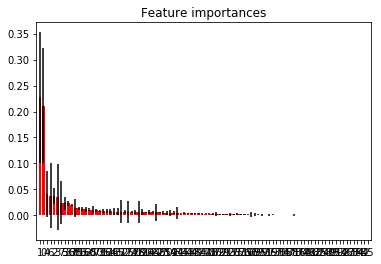

In [16]:
ranked_list = feature_importance(et_all, X_tr_1.drop(categorical_cols, axis=1))

In [17]:
cols_to_drop = ranked_list[75:]
matching = [s for s in cols_to_drop if ("lag_" not in s)]
matching

['item_category_name_tfidf_8',
 'item_name_tfidf_15',
 'item_name_tfidf_3',
 'item_category_name_tfidf_9',
 'shop_name_tfidf_13',
 'shop_name_tfidf_16',
 'item_category_name_tfidf_2',
 'item_name_tfidf_2',
 'item_name_tfidf_1',
 'shop_name_tfidf_22',
 'item_name_tfidf_22',
 'shop_name_tfidf_23',
 'item_name_tfidf_10',
 'shop_name_tfidf_14',
 'shop_name_tfidf_4',
 'shop_name_tfidf_15',
 'item_category_name_tfidf_11',
 'item_name_tfidf_4',
 'item_name_tfidf_9']

In [5]:
matching = ['item_category_name_tfidf_8',
 'item_name_tfidf_15',
 'item_name_tfidf_3',
 'item_category_name_tfidf_9',
 'shop_name_tfidf_13',
 'shop_name_tfidf_16',
 'item_category_name_tfidf_2',
 'item_name_tfidf_2',
 'item_name_tfidf_1',
 'shop_name_tfidf_22',
 'item_name_tfidf_22',
 'shop_name_tfidf_23',
 'item_name_tfidf_10',
 'shop_name_tfidf_14',
 'shop_name_tfidf_4',
 'shop_name_tfidf_15',
 'item_category_name_tfidf_11',
 'item_name_tfidf_4',
 'item_name_tfidf_9']

## Stack level 2 Model

Add Model Level 1 result for data process for stack level 2 

In [6]:
nn_preds_2 = np.load("./Processed_data/nn_preds_2_7.npy")
nn_preds_3 = np.load("./Processed_data/nn_preds_3_7.npy")
nn_preds_test = np.load("./Processed_data/nn_preds_test_3_7.npy")

lm_preds2 = np.load("./Processed_data/lm_preds2_7.npy")
lm_preds3 = np.load("./Processed_data/lm_preds3_7.npy")
lm_preds_te = np.load("./Processed_data/lm_preds_te_avg_7.npy")

lgb_test_preds = np.load("./Processed_data/lgb_test_preds_7_avg.npy")
lgb_preds_3 = np.load("./Processed_data/lgb_preds_3_7.npy")
lgb_preds_2 = np.load("./Processed_data/lgb_preds_2_7.npy")

et_test_preds_3 = np.load("./Processed_data/et_test_preds_7_avg.npy")
et_preds_3 = np.load("./Processed_data/et_preds_3_7.npy")
et_preds_2 = np.load("./Processed_data/et_preds_2_7.npy")


In [7]:
X_tr_2['lgb_7'] = lgb_preds_2.clip(*[-1,25])
X_tr_2['nn_7'] = nn_preds_2.clip(*[-1,25])
X_tr_2['lm_7'] = lm_preds2.clip(*[-1,25])
X_tr_2['et_7'] = et_preds_2.clip(*[-1,25])

X_tr_3['lgb_7'] = lgb_preds_3.clip(*[-1,25])
X_tr_3['nn_7'] = nn_preds_3.clip(*[-1,25])
X_tr_3['lm_7'] = lm_preds3.clip(*[-1,25])
X_tr_3['et_7'] = et_preds_3.clip(*[-1,25])

X_test['lgb_7'] = lgb_test_preds.clip(*[-1,25])
X_test['nn_7'] = nn_preds_test.clip(*[-1,25])
X_test['lm_7'] = lm_preds_te.clip(*[-1,25])
X_test['et_7'] = et_test_preds_3.clip(*[-1,25])

In [10]:
y_tr_3 = np.load("./Process_data/y_tr_3.npy")
y_tr_2 = np.load("./Process_data/y_tr_2.npy")
y_tr_3 = y_tr_3.clip(*[0,25])
y_tr_2 = y_tr_2.clip(*[0,25])

print("y_tr_2:", y_tr_2.shape)
print("y_tr_3:", y_tr_3.shape)

# create our targets - since each model was used to predict the other dataset we reverse our targets
y_train = np.squeeze(np.concatenate([y_tr_2, y_tr_3], axis=0)).clip(*[0,25])

y_tr_2: (1846931,)
y_tr_3: (1614364,)


In [11]:
X_tr_2.drop(matching, axis=1, inplace=True)
X_tr_3.drop(matching, axis=1, inplace=True)
X_test.drop(matching, axis=1, inplace=True)

lag_cols = [s for s in X_tr_2.columns if "lag_" in s]
id_cols = [s for s in X_tr_2.columns if "_id" in s]
text_cols = [s for s in X_tr_2.columns if ("tfidf" in s) or ("_wc" in s)  or ("_len" in s) ]
pred_cols = [s for s in X_tr_2.columns if (("_0" in s) or ("_7" in s)) and ('lag' not in s) and ('tfidf' not in s) and (s != "m_5")]

num_grouped_cols = len(lag_cols) + len(id_cols) + len(text_cols) + len(pred_cols)

print("Grouped Columns:", num_grouped_cols)
print("Total Columns:", len(X_tr_2.columns))

Grouped Columns: 82
Total Columns: 83


In [12]:
X_train = pd.concat([X_tr_2, X_tr_3], axis=0)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:",X_test.shape)

X_train: (3461295, 83)
y_train: (3461295,)
X_test: (214200, 83)


In [13]:
X_train.to_pickle("./Process_data/X_train_level_2.pkl")
X_tr_2.to_pickle("./Process_data/X_tr_2_level_2.pkl")
X_tr_3.to_pickle("./Process_data/X_tr_3_level_2.pkl")
X_test.to_pickle("./Process_data/X_test_level_2.pkl")

np.save("./Process_data/y_train_level_2.npy", y_train)
np.save("./Process_data/y_tr_2_level_2.npy", y_tr_2)
np.save("./Process_data/y_tr_3_level_2.npy", y_tr_3)

In [13]:
X_train = pd.read_pickle("./Process_data/X_train_level_2.pkl")
X_tr_2 = pd.read_pickle("./Process_data/X_tr_2_level_2.pkl")
X_tr_3 = pd.read_pickle("./Process_data/X_tr_3_level_2.pkl")
X_test = pd.read_pickle("./Process_data/X_test_level_2.pkl")

y_train = np.load("./Process_data/y_train_level_2.npy", y_train)
y_tr_2 = np.load("./Process_data/y_tr_2_level_2.npy", y_tr_2)
y_tr_3 = np.load("./Process_data/y_tr_3_level_2.npy", y_tr_3)

##  Model 1 : LGB Regressor

In [15]:
lgb_drop_cols = []

In [16]:
# make this tree shallower
lgb_params = {
                'feature_fraction': .75,
                'metric': 'mse',
                'max_depth': 20,
                'nthread':6, 
                'min_data_in_leaf': 20, 
                'bagging_fraction': 0.75, 
                'boosting_type': 'gbdt',
                'learning_rate': 0.03, 
                'objective': 'mse', 
                'application': 'regression',
                'objective': 'regression',
                'bagging_seed': 2407, 
                'num_leaves': 2**9,
                'bagging_freq':1,
                'verbose':1,
              }

lgb_stacked2 = lgb.train(lgb_params, lgb.Dataset(X_tr_2.drop(lgb_drop_cols, axis=1)
                                                 , label=y_tr_2, categorical_feature=id_cols), 100)

/home/minomi016/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [17]:
lgb2_train_preds_3 = lgb_stacked2.predict(X_tr_3.drop(lgb_drop_cols, axis=1))

lgb_mse = mean_squared_error(y_tr_3, lgb2_train_preds_3)
lgb_mse_clipped = mean_squared_error(y_tr_3, lgb2_train_preds_3.clip(*[0,25]))

print("LGB MSE:", lgb_mse)
print("LGB Clipped MSE:", lgb_mse_clipped)

LGB MSE: 0.915895506261
LGB Clipped MSE: 0.915894816801


In [24]:
# let's see which features are important so we can exclude features that aren't
importances = lgb_stacked2.feature_importance()

# remove the last column since that was not used the the gbm
cols = X_train.drop([], axis=1).columns

# create a dataframe to map the column name to the importance
feature_importances = pd.DataFrame({ 'col': cols, 'importance':importances })

# sort the dataframe
feature_importances.sort_values(by="importance", inplace=True)

feature_importances

,col,importance
52,item_category_name_tfidf_0,3
63,item_category_name_tfidf_23,4
68,shop_name_tfidf_2,4
59,item_category_name_tfidf_17,6
71,shop_name_tfidf_9,10
60,item_category_name_tfidf_20,13
67,shop_name_tfidf_0,20
61,item_category_name_tfidf_21,20
57,item_category_name_tfidf_14,25
64,item_category_name_tfidf_24,27


In [25]:
important_features = feature_importances.iloc[30:].col.values
unimportant_features = feature_importances.iloc[:45].col.values
lgb_drop_cols = unimportant_features

In [21]:
lgb2_results = ["lgb2", float('NaN'), lgb_mse ]
mse_results.loc[4] = lgb2_results
mse_results.to_pickle("mse_results.pkl")
mse_results

,model,2,3
0,linear,1.548105,1.130952
1,nn,1.353402,1.022426
4,lgb2,NaN,0.915896
2,lgb,1.270162,1.010710
3,extra trees,1.105885,0.801063
6,lgb2,NaN,0.915896


In [19]:
mse_results = pd.read_pickle("./Processed_data/mse_results.pkl")

In [22]:
lgb_stacked3 = lgb.train(lgb_params, lgb.Dataset(X_train.drop(lgb_drop_cols, axis=1)
                                                 , label=y_train, categorical_feature=id_cols), 100)
lgb2_test_preds_1 = lgb_stacked3.predict(X_test.drop(lgb_drop_cols, axis=1))

/home/minomi016/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/minomi016/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [23]:
lgb_stacked4 = lgb.train(lgb_params, lgb.Dataset(X_tr_3.drop(lgb_drop_cols, axis=1), label=y_tr_3, categorical_feature=id_cols), 100)
lgb2_test_preds_2 = lgb_stacked4.predict(X_test.drop(lgb_drop_cols, axis=1))

lgb2_test_preds_3 = (lgb2_test_preds_1 + lgb2_test_preds_2) / 2

/home/minomi016/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1040: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/minomi016/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


## Model 2 : linear

In [26]:
lm_use_cols = pred_cols
lm_stacked2 = LinearRegression(n_jobs=-1)
lm_stacked2.fit(X_tr_2[lm_use_cols], y_tr_2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [27]:
# predict on dataset 3
lm2_train_preds_3 = lm_stacked2.predict(X_tr_3[lm_use_cols])

lm2_mse = mean_squared_error(y_tr_3, lm2_train_preds_3)
lm2_mse_clipped = mean_squared_error(y_tr_3, lm2_train_preds_3.clip(*[0,25]))

print("LM MSE:", lm2_mse)
print("LM Clipped MSE:", lm2_mse_clipped)

# the clipped predictions are better so let's use those
lm2_train_preds_3 = lm2_train_preds_3.clip(*[0,25])

LM MSE: 0.798675909854
LM Clipped MSE: 0.798550972697


In [28]:
# make sure the results are improving
lm2_results = ["linear2", float('NaN'), lm2_mse_clipped ]
mse_results.loc[5] = lm2_results
mse_results.to_pickle("mse_results.pkl")
mse_results

,model,2,3
0,linear,1.548105,1.130952
1,nn,1.353402,1.022426
4,lgb2,NaN,0.915896
2,lgb,1.270162,1.010710
3,extra trees,1.105885,0.801063
6,lgb2,NaN,0.915896
5,linear2,NaN,0.798551


In [29]:
# fit a model to combine datasets to predict for test
lm_stacked3 = LinearRegression(n_jobs=-1)
lm_stacked3.fit(X_train[lm_use_cols], y_train)
# make our predictions on test data
lm2_test_preds_1 = lm_stacked3.predict(X_test[lm_use_cols])

In [30]:
# fit a model to combine datasets to predict for test
lm_stacked4 = LinearRegression(n_jobs=-1)
lm_stacked4.fit(X_tr_3[lm_use_cols], y_tr_3)
lm2_test_preds_2 = lm_stacked4.predict(X_test[lm_use_cols])

lm2_test_preds_3 = (lm2_test_preds_2 + lm2_test_preds_1) / 2

## Model 3 : Extract tree

In [31]:
# exclude our ids
etr_cols_to_drop = []
etr_cols_to_drop = id_cols + text_cols

In [32]:
# keep the model small since we are only using it to evaluate feature importance
stack_forest2 = ExtraTreesRegressor(n_estimators=5, random_state=0, max_depth=10
                                    , min_impurity_decrease=1e-5, min_samples_leaf=25, n_jobs=4, verbose=1)

# fit model to dataset 2 to predict for 3
stack_forest2.fit(X_tr_2.drop(etr_cols_to_drop, axis=1), y_tr_2)

[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   19.4s finished


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=10,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=1e-05, min_impurity_split=None,
          min_samples_leaf=25, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=4,
          oob_score=False, random_state=0, verbose=1, warm_start=False)

In [33]:
et2_preds_3 = stack_forest2.predict(X_tr_3.drop(etr_cols_to_drop, axis=1))
et2_mse = mean_squared_error(y_tr_3, et2_preds_3)
print("ET MSE:", et2_mse)

ET MSE: 0.786008261497


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.2s finished


Feature ranking:
1. feature 40 (0.485630) - et_7
2. feature 38 (0.240215) - nn_7
3. feature 37 (0.072936) - lgb_7
4. feature 0 (0.063013) - target_lag_1
5. feature 36 (0.036736) - month_number
6. feature 39 (0.035050) - lm_7
7. feature 7 (0.015306) - target_item_lag_3
8. feature 2 (0.010735) - target_shop_lag_1
9. feature 6 (0.005990) - target_lag_3
10. feature 1 (0.005035) - target_item_lag_1
11. feature 10 (0.004969) - target_item_lag_4
12. feature 3 (0.004074) - target_lag_2
13. feature 11 (0.003990) - target_shop_lag_4
14. feature 5 (0.002714) - target_shop_lag_2
15. feature 4 (0.002511) - target_item_lag_2
16. feature 8 (0.002230) - target_shop_lag_3
17. feature 17 (0.001646) - target_shop_lag_6
18. feature 14 (0.000927) - target_shop_lag_5
19. feature 35 (0.000913) - target_shop_lag_12
20. feature 29 (0.000881) - target_shop_lag_10
21. feature 13 (0.000600) - target_item_lag_5
22. feature 22 (0.000556) - target_item_lag_8
23. feature 23 (0.000521) - target_shop_lag_8
24. feature 

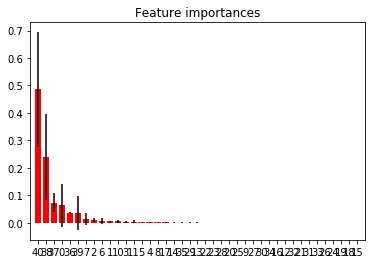

In [34]:
#let's drop some more un-important columns before we fit our last model
ranked_list = feature_importance(stack_forest2, X_tr_2.drop(etr_cols_to_drop, axis=1))

In [35]:
# only use the top 11 features for these models
features_to_use = ranked_list[:11]

In [36]:
stack_forest2 = ExtraTreesRegressor(n_estimators=30, random_state=0, max_depth=10, min_impurity_decrease=1e-5, min_samples_leaf=20, n_jobs=-1, verbose=1)

# fit model to dataset 2 to predict for 3
stack_forest2.fit(X_tr_2[features_to_use], y_tr_2)

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.9s finished


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=10,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=1e-05, min_impurity_split=None,
          min_samples_leaf=20, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
          oob_score=False, random_state=0, verbose=1, warm_start=False)

In [37]:
et2_preds_3 = stack_forest2.predict(X_tr_3[features_to_use])
et2_mse = mean_squared_error(y_tr_3, et2_preds_3)
print("ET MSE:", et2_mse)

ET MSE: 0.777657623644


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    1.0s finished


In [38]:
# make sure the results are improving
et2_results = ["et2", float('NaN'), et2_mse ]
mse_results.loc[6] = et2_results
mse_results.to_pickle("mse_results.pkl")
mse_results

,model,2,3
0,linear,1.548105,1.130952
1,nn,1.353402,1.022426
4,lgb2,NaN,0.915896
2,lgb,1.270162,1.010710
3,extra trees,1.105885,0.801063
6,et2,NaN,0.777658
5,linear2,NaN,0.798551


In [39]:
# fit to combine datasets to predict for test
stack_forest3 = ExtraTreesRegressor(n_estimators=30, random_state=0, max_depth=10
                                    , min_impurity_decrease=1e-5, min_samples_leaf=20, n_jobs=-1, verbose=1)

# fit model to dataset 2 to predict for 3
stack_forest3.fit(X_train[features_to_use], y_train)

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   44.6s finished


ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=10,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=1e-05, min_impurity_split=None,
          min_samples_leaf=20, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
          oob_score=False, random_state=0, verbose=1, warm_start=False)

In [40]:
et2_test_preds_1 = stack_forest3.predict(X_test[features_to_use])

[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.1s finished


In [41]:
# fit to combine datasets to predict for test
stack_forest4 = ExtraTreesRegressor(n_estimators=30, random_state=0, max_depth=10
                                    , min_impurity_decrease=1e-5, min_samples_leaf=20, n_jobs=-1, verbose=1)

# fit model to dataset 2 to predict for 3
stack_forest4.fit(X_tr_3[features_to_use], y_tr_3)

et2_test_preds_2 = stack_forest4.predict(X_test[features_to_use])
et2_test_preds_3 = (et2_test_preds_2 + et2_test_preds_1) / 2

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.9s finished
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.1s finished


## Model 4 : Random Forest

In [42]:
rf_drop_cols = id_cols + text_cols
# tweak our parameters to try to get our predictions to improve
stack_rf2 = RandomForestRegressor(n_estimators=3, random_state=10, max_depth=10, min_impurity_decrease=1e-7, min_samples_leaf=20, n_jobs=-1, verbose=1)

# fit model to dataset 2 to predict for 3
stack_rf2.fit(X_tr_2.drop(rf_drop_cols, axis=1), y_tr_2)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   39.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=1e-07, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=-1,
           oob_score=False, random_state=10, verbose=1, warm_start=False)

In [43]:
rf2_preds_3 = stack_rf2.predict(X_tr_3.drop(rf_drop_cols, axis=1))
rf2_mse = mean_squared_error(y_tr_3, rf2_preds_3)
print("RF MSE:", rf2_mse)

RF MSE: 0.803047640101


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished


Feature ranking:
1. feature 40 (0.655970) - et_7
2. feature 37 (0.115747) - lgb_7
3. feature 0 (0.095752) - target_lag_1
4. feature 36 (0.040548) - month_number
5. feature 38 (0.028825) - nn_7
6. feature 1 (0.013136) - target_item_lag_1
7. feature 39 (0.011666) - lm_7
8. feature 2 (0.005636) - target_shop_lag_1
9. feature 6 (0.005447) - target_lag_3
10. feature 4 (0.005427) - target_item_lag_2
11. feature 3 (0.004531) - target_lag_2
12. feature 7 (0.002852) - target_item_lag_3
13. feature 10 (0.002215) - target_item_lag_4
14. feature 8 (0.001366) - target_shop_lag_3
15. feature 5 (0.001211) - target_shop_lag_2
16. feature 16 (0.001200) - target_item_lag_6
17. feature 33 (0.001157) - target_lag_12
18. feature 9 (0.001101) - target_lag_4
19. feature 13 (0.000591) - target_item_lag_5
20. feature 19 (0.000504) - target_item_lag_7
21. feature 32 (0.000484) - target_shop_lag_11
22. feature 34 (0.000478) - target_item_lag_12
23. feature 25 (0.000457) - target_item_lag_9
24. feature 30 (0.0004

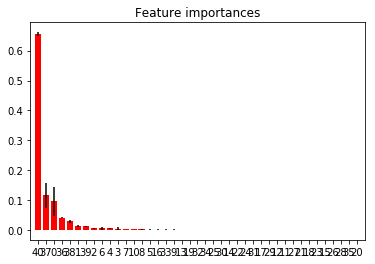

In [44]:
# let's drop some more un-important columns before we fit our last model
ranked_list = feature_importance(stack_rf2, X_tr_2.drop(rf_drop_cols, axis=1))

In [45]:
# this time let's keep the set of features small
features_to_use = ranked_list[:10]

In [46]:
# tweak our parameters to try to get our predictions to improve
stack_rf2 = RandomForestRegressor(n_estimators=25, random_state=10, max_depth=10, min_impurity_decrease=1e-7, min_samples_leaf=20, n_jobs=-1, verbose=1)

# fit model to dataset 2 to predict for 3
stack_rf2.fit(X_tr_2[features_to_use], y_tr_2)
rf2_preds_3 = stack_rf2.predict(X_tr_3[features_to_use])
rf2_mse = mean_squared_error(y_tr_3, rf2_preds_3)
print("RF MSE:", rf2_mse)

[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.0min finished


RF MSE: 0.792666546785


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.9s finished


In [47]:
# make sure the results are improving
rf2_results = ["rf2", float("NaN"), rf2_mse ]
mse_results.loc[7] = rf2_results
mse_results.to_pickle("./Processed_data/mse_results.pkl")
mse_results

,model,2,3
0,linear,1.548105,1.130952
1,nn,1.353402,1.022426
4,lgb2,NaN,0.915896
2,lgb,1.270162,1.010710
3,extra trees,1.105885,0.801063
6,et2,NaN,0.777658
5,linear2,NaN,0.798551
7,rf2,NaN,0.792667


In [49]:
stack_rf3 = RandomForestRegressor(n_estimators=25, random_state=10, max_depth=10, min_impurity_decrease=1e-7, min_samples_leaf=20, n_jobs=-1, verbose=1)

stack_rf3.fit(X_train[features_to_use], y_train)
rf2_preds_te = stack_rf3.predict(X_test[features_to_use])

[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  4.4min finished
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished


In [50]:
stack_rf4 = RandomForestRegressor(n_estimators=25, random_state=10, max_depth=10, min_impurity_decrease=1e-7, min_samples_leaf=20, n_jobs=-1, verbose=1)

stack_rf4.fit(X_tr_3[features_to_use], y_tr_3)
rf2_preds_te_2 = stack_rf4.predict(X_test[features_to_use])

[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.7min finished
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.2s finished


In [51]:
rf2_preds_te_3 = (rf2_preds_te_2 + rf2_preds_te) / 2
print("MSE of Two Test Preds:", mean_squared_error(rf2_preds_te_2, rf2_preds_te))

MSE of Two Test Preds: 0.0358677291028


## Stack Level 3 Model 
### In this level , I will train a model for finding the useful parameters , and use those parameters to train the final model

In [52]:
# drop our text and id columns
X_tr_3.drop(id_cols + text_cols, axis=1, inplace=True)
X_test.drop(id_cols + text_cols, axis=1, inplace=True)
X_tr_3.columns
cols = X_tr_3.columns[9:33]
cols_to_drop = cols[3:33]
cols_to_drop

Index(['target_lag_5', 'target_item_lag_5', 'target_shop_lag_5',
       'target_lag_6', 'target_item_lag_6', 'target_shop_lag_6',
       'target_lag_7', 'target_item_lag_7', 'target_shop_lag_7',
       'target_lag_8', 'target_item_lag_8', 'target_shop_lag_8',
       'target_lag_9', 'target_item_lag_9', 'target_shop_lag_9',
       'target_lag_10', 'target_item_lag_10', 'target_shop_lag_10',
       'target_lag_11', 'target_item_lag_11', 'target_shop_lag_11'],
      dtype='object')

In [53]:
X_tr_3.drop(cols_to_drop, axis=1, inplace=True)
X_test.drop(cols_to_drop, axis=1, inplace=True)

In [54]:
X_tr_3['lgb_l2'] = lgb2_train_preds_3.clip(*[0,22])
X_tr_3['lm_l2'] = lm2_train_preds_3.clip(*[0,22])
X_tr_3['et_l2'] = et2_preds_3.clip(*[0,22])
X_tr_3['rf_l2'] = rf2_preds_3.clip(*[0,22])

X_test['lgb_l2'] = lgb2_test_preds_3.clip(*[0,22])
X_test['lm_l2'] = lm2_test_preds_3.clip(*[0,22])
X_test['et_l2'] = et2_test_preds_3.clip(*[0,22])
X_test['rf_l2'] = rf2_preds_te_3.clip(*[0,22])

In [55]:
lag_cols = []
pred_cols= []

# make lists of columns again
for col in X_tr_3.columns:
    if "lag_" in col:
        lag_cols.append(col)
    else:
        pred_cols.append(col)
        
print("Lags:", lag_cols)
print("Preds:", pred_cols)

Lags: ['target_lag_1', 'target_item_lag_1', 'target_shop_lag_1', 'target_lag_2', 'target_item_lag_2', 'target_shop_lag_2', 'target_lag_3', 'target_item_lag_3', 'target_shop_lag_3', 'target_lag_4', 'target_item_lag_4', 'target_shop_lag_4', 'target_lag_12', 'target_item_lag_12', 'target_shop_lag_12']
Preds: ['month_number', 'lgb_7', 'nn_7', 'lm_7', 'et_7', 'lgb_l2', 'lm_l2', 'et_l2', 'rf_l2']


In [56]:
y_tr_3 = y_tr_3.clip(*[0,20])
X_tr_3.to_pickle("./Processed_data/X_tr_3_level3.pkl")
X_test.to_pickle("./Processed_data/X_test_level3.pkl")
np.save("./Processed_data/y_tr_3.npy", y_tr_3)

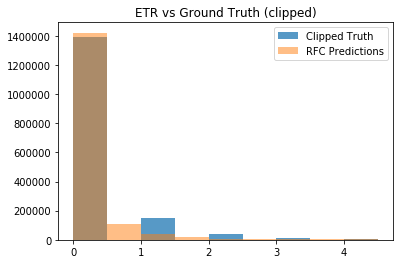

In [57]:
plt.hist(y_tr_3, bins=np.arange(0,5,0.5), label="Clipped Truth", alpha=0.75)
plt.hist(X_tr_3.et_l2, bins=np.arange(0,5,0.5), label="RFC Predictions", alpha=0.5)
plt.title("ETR vs Ground Truth (clipped)")
plt.legend()
plt.show()

In [58]:
print("X_tr_3 MSE:", mean_squared_error(y_tr_3, X_tr_3.et_l2))
print("X_tr_3 Rounded MSE:", mean_squared_error(y_tr_3, round(X_tr_3.et_l2)))
print("X_tr_3 Rounded MSE:", mean_squared_error(y_tr_3, (round(X_tr_3.et_l2) + 7 * X_tr_3.et_l2) / 8))

X_tr_3 MSE: 0.686670243717
X_tr_3 Rounded MSE: 0.718355339936
X_tr_3 Rounded MSE: 0.686872094605


## Final Model 1 : Linear model

In [59]:
final_lm = LinearRegression(n_jobs=-1)
final_lm.fit(X_tr_3, y_tr_3)
final_lm_preds = final_lm.predict(X_tr_3)

print("MSE:", mean_squared_error(y_tr_3, final_lm_preds))

MSE: 0.672172678614


In [60]:
stacked_mse = pd.DataFrame(columns=["model", "mse"])
stacked_mse.loc[0] = ["lm1", mean_squared_error(y_tr_3, final_lm_preds)]
stacked_mse

,model,mse
0,lm1,0.672173


In [61]:
final_lm_test_preds = final_lm.predict(X_test)

In [62]:
pos_coefs = []
for i in range(len(X_tr_3.columns)):
    print(X_tr_3.columns[i], "   -   ", final_lm.coef_[i])
    if final_lm.coef_[i] > 0:
        pos_coefs.append(X_tr_3.columns[i])
        
print()
print("Positive Coeffs:", pos_coefs)

target_lag_1    -    0.00266852860716
target_item_lag_1    -    -0.00055034338828
target_shop_lag_1    -    1.28969680693e-05
target_lag_2    -    0.0126572606171
target_item_lag_2    -    0.000586556442171
target_shop_lag_2    -    3.27089915392e-06
target_lag_3    -    0.00213674922031
target_item_lag_3    -    0.000136722590735
target_shop_lag_3    -    -3.41762833115e-06
target_lag_4    -    0.00551427121255
target_item_lag_4    -    -0.000165127436218
target_shop_lag_4    -    -1.212265678e-05
target_lag_12    -    -0.00624987355646
target_item_lag_12    -    -0.000117074928894
target_shop_lag_12    -    -6.73926910809e-06
month_number    -    0.00495648466794
lgb_7    -    -0.167127868355
nn_7    -    -0.0407999123668
lm_7    -    0.0371739566592
et_7    -    -0.0826705593319
lgb_l2    -    0.0344374944258
lm_l2    -    0.554592388845
et_l2    -    0.375886905096
rf_l2    -    0.172018952858

Positive Coeffs: ['target_lag_1', 'target_shop_lag_1', 'target_lag_2', 'target_item_lag_

In [67]:
test       = pd.read_csv('./final_project_data/test.csv')
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [68]:
test['lm_item_cnt_month'] = final_lm_test_preds.clip(*[0,20])

In [69]:
final_lm3 = LinearRegression(n_jobs=-1)
final_lm3.fit(X_tr_3[pos_coefs], y_tr_3)
final_lm_preds3 = final_lm3.predict(X_tr_3[pos_coefs])

print("MSE:", mean_squared_error(y_tr_3, final_lm_preds3))
print("Max:", np.max(final_lm_preds3))

MSE: 0.675982953973
Max: 29.9975356946


In [70]:
stacked_mse.loc[1] = ["lm_pos", mean_squared_error(y_tr_3, final_lm_preds3)]
stacked_mse
final_lm_test_preds3 = final_lm3.predict(X_test[pos_coefs])
print("Max:", np.max(final_lm_test_preds3))

Max: 26.5855636831


In [71]:
test['lm3_item_cnt_month'] = final_lm_test_preds3.clip(*[0,20])

In [72]:
final_lm2 = LinearRegression(n_jobs=-1)
final_lm2.fit(X_tr_3[pred_cols], y_tr_3)
final_lm_preds2 = final_lm2.predict(X_tr_3[pred_cols])

print("MSE:", mean_squared_error(y_tr_3, final_lm_preds2))

MSE: 0.676755064951


In [73]:
stacked_mse.loc[2] = ["lm_preds", mean_squared_error(y_tr_3, final_lm_preds2)]
stacked_mse
final_lm_test_preds2 = final_lm2.predict(X_test[pred_cols]).clip(*[0,20])
print("Max:", np.max(final_lm_test_preds2))

Max: 20.0


In [74]:
test['lm2_item_cnt_month'] = final_lm_test_preds2

## Final Model 2 : Random Forest

In [75]:
final_forest = RandomForestRegressor(n_estimators=25, random_state=13, max_depth=10, min_impurity_decrease=1e-6, min_samples_leaf=25, n_jobs=-1, verbose=1)
final_forest.fit(X_tr_3, y_tr_3)

[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  3.5min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=1e-06, min_impurity_split=None,
           min_samples_leaf=25, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
           oob_score=False, random_state=13, verbose=1, warm_start=False)

In [76]:
# score on the data we trained on just for comparison
ff_preds = final_forest.predict(X_tr_3)
ff_mse = mean_squared_error(y_tr_3, ff_preds)

print("MSE:", ff_mse)

MSE: 0.601317097898


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.9s finished


In [77]:
stacked_mse.loc[3] = ["rf", mean_squared_error(y_tr_3, ff_preds)]
stacked_mse
# predict on test data
final_rf_test_preds = final_forest.predict(X_test)
np.save("ff_test_preds_6.npy", final_rf_test_preds)

[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished


In [78]:
np.max(final_rf_test_preds)
test['rf_item_cnt_month'] = final_rf_test_preds.clip(*[0,20])
test.to_pickle("./Processed_data/test_w_preds.pkl")

In [79]:
final_forest2 = RandomForestRegressor(n_estimators=25, random_state=13, max_depth=10, min_impurity_decrease=1e-6, min_samples_leaf=20, n_jobs=-1, verbose=1)
final_forest2.fit(X_tr_3[pred_cols], y_tr_3)
ff_preds2 = final_forest2.predict(X_tr_3[pred_cols])
ff_mse2 = mean_squared_error(y_tr_3, ff_preds2)

print("MSE:", ff_mse2)

[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.4min finished


MSE: 0.608065681763


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.8s finished


In [80]:
stacked_mse.loc[4] = ["rf_preds", mean_squared_error(y_tr_3, ff_preds2)]
stacked_mse
final_rf_test_preds2 = final_forest2.predict(X_test[pred_cols])
print("Max:", np.max(final_rf_test_preds2))
np.save("ff_test_preds_2_6.npy", final_rf_test_preds2)

Max: 19.9930583181


[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:    0.1s finished


In [81]:
test['rf_item_cnt_month2'] = final_rf_test_preds2.clip(*[0,20])
test.to_pickle("./Processed_data/test_w_preds.pkl")

## Final Model 3 : LGB

In [82]:
lgb_params = {
                'feature_fraction': .75,
                'metric': 'mse',
                'max_depth': 15,
                'nthread':6, 
                'min_data_in_leaf': 10, 
                'bagging_fraction': 0.75, 
                'boosting_type': 'gbdt',
                'learning_rate': 0.03, 
                'objective': 'mse', 
                'application': 'regression',
                'objective': 'regression',
                'bagging_seed': 2407, 
                'num_leaves': 2**9,
                'bagging_freq':1,
                'verbose':1,
              }

final_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr_3,label= y_tr_3), 100)

In [83]:
final_lgb_preds = final_lgb.predict(X_tr_3)
final_lgb_mse = mean_squared_error(y_tr_3, final_lgb_preds)

print("MSE:", final_lgb_mse)

MSE: 0.476370653113


In [84]:
stacked_mse.loc[5] = ["lgb", final_lgb_mse]
stacked_mse
final_lgb_test_preds = final_lgb.predict(X_test)
print("Max:", np.max(final_lgb_test_preds))

Max: 19.1426937912


In [85]:
test['lgb_item_cnt_month'] = final_lgb_test_preds
test[["ID", "lgb_item_cnt_month"]].to_csv("20180725_lgb_final_new.csv", header=["ID", "item_cnt_month"], index=False)

In [86]:
lgb_params = {
                'feature_fraction': .75,
                'metric': 'mse',
                'max_depth': 15,
                'nthread':4, 
                'min_data_in_leaf': 20, 
                'bagging_fraction': 0.75, 
                'boosting_type': 'gbdt',
                'learning_rate': 0.03, 
                'objective': 'mse', 
                'objective': 'regression',
                'bagging_seed': 2407, 
                'num_leaves': 2**9,
                'bagging_freq':1,
                'verbose':2,
              }
final_lgb2 = lgb.train(lgb_params, lgb.Dataset(X_tr_3[pred_cols],label= y_tr_3), 100)

In [87]:
final_lgb_preds2 = final_lgb2.predict(X_tr_3[pred_cols])
final_lgb_mse2 = mean_squared_error(y_tr_3, final_lgb_preds2)

print("MSE:", final_lgb_mse2)
print("Max:", np.max(final_lgb_preds2))

MSE: 0.584158191829
Max: 17.676565402


In [88]:
stacked_mse.loc[6] = ["lgb_preds", final_lgb_mse2]
stacked_mse

,model,mse
0,lm1,0.672173
1,lm_pos,0.675983
2,lm_preds,0.676755
3,rf,0.601317
4,rf_preds,0.608066
5,lgb,0.476371
6,lgb_preds,0.584158


In [91]:
final_lgb_test_preds2 = final_lgb2.predict(X_test[pred_cols])
print("Max:", np.max(final_lgb_test_preds2))
test['lgb_item_cnt_month2'] = final_lgb_test_preds2

Max: 12.1438740358


In [93]:
test.head()

,ID,shop_id,item_id,lm_item_cnt_month,lm3_item_cnt_month,lm2_item_cnt_month,rf_item_cnt_month,rf_item_cnt_month2,lgb_item_cnt_month,lgb_item_cnt_month2
0,0,5,5037,0.657617,0.627546,0.620372,0.775235,0.658678,0.661819,0.635214
1,1,5,5320,0.261580,0.249188,0.264817,0.220781,0.218335,0.218740,0.200038
2,2,5,5233,0.887828,0.850879,0.850332,0.985467,0.934715,0.916285,0.847754
3,3,5,5232,0.655792,0.626069,0.634864,0.729238,0.639419,0.663530,0.609056
4,4,5,5268,5.153497,4.709488,5.139327,4.171311,4.824730,3.457588,4.531997


# Result 

In [96]:
test.columns

Index(['ID', 'shop_id', 'item_id', 'lm_item_cnt_month', 'lm3_item_cnt_month',
       'lm2_item_cnt_month', 'rf_item_cnt_month', 'rf_item_cnt_month2',
       'lgb_item_cnt_month', 'lgb_item_cnt_month2'],
      dtype='object')

In [103]:
Avg_col = list(set(test.columns) - set(['ID', 'item_id', 'shop_id']))
print(Avg_col)

['rf_item_cnt_month', 'lm2_item_cnt_month', 'rf_item_cnt_month2', 'lgb_item_cnt_month2', 'lm3_item_cnt_month', 'lgb_item_cnt_month', 'lm_item_cnt_month']


In [106]:
test["Avg"] = np.mean(test[Avg_col], axis = 1)

In [107]:
test[["ID", "Avg"]].to_csv("20180725_Avg_new.csv", header=["ID", "item_cnt_month"], index=False)